In [ ]:
'''
U-Net Implementation
'''

## DataSet

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode



from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample

import cv2
from torch.utils.data import Dataset

In [ ]:
!gdown --id 1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
!gdown --id 1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl

In [ ]:
%mkdir Dataset
%mkdir Dataset/2d_images
%mkdir Dataset/2d_masks

In [ ]:

!unzip -q 2d_images.zip.zip 
!unzip -q 2d_images.zip -d Dataset/2d_images

!unzip -q 2d_masks.zip.zip 
!unzip -q 2d_masks.zip -d Dataset/2d_masks

In [ ]:
!rm -rf 2d_images.zip.zip
!rm -rf 2d_images.zip

!rm -rf 2d_masks.zip.zip
!rm -rf 2d_masks.zip

## DataLoader

In [ ]:
class CT_Data(Dataset):

    def __init__(self, csv_file, root_dir):

        self.image_frame = pd.read_csv(csv_file, skiprows=1)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 0])
        mask_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 1])
        image = cv2.imread(img_name, 0)
        image = cv2.resize(image,(32, 32))
        image = image.reshape((1, 32, 32))
        mask = cv2.imread(mask_name, 0)
        mask = cv2.resize(mask, (32, 32))
        mask = mask.reshape((1, 32, 32))
        sample = {'image': image, 'mask': mask}
        return sample

In [ ]:
img_dir = "Dataset/2d_images/"
msk_dir = "Dataset/2d_masks/"
with open('Dataset/Dataset.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(img_dir):
        image_path = os.path.join(img_dir, p)
        mask_path = os.path.join(msk_dir, p)
        writer.writerow([image_path, mask_path])


data = pd.read_csv("Dataset/Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
partition = int(len(data)*0.7)
train, validation = data[:partition], data[partition:]
train.to_csv("Dataset/Train.csv", index=False)
validation.to_csv("Dataset/Validation.csv", index=False)

train_dataset = CT_Data(csv_file='Dataset/Train.csv', root_dir='/content')
val_dataset = CT_Data(csv_file='Dataset/Validation.csv', root_dir='/content')
train_dataloader = DataLoader(train_dataset, batch_size=37, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=4)

## U-Net Model

In [ ]:

class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()
        ###########################################
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            Conv2D(
                  channel_in,
                   channel_out,
                   kernel_size=3,
                   padding=1),
                   nn.BatchNorm2d(channel_out),
                   nn.ReLU(inplace=True)
        )
        ###########################################

    def forward(self, x1, x2):
        ###########################################
        x1 = self.upsample(x1)
        diff_x = x1.size()[2] - x2.size()[2]
        diff_y = x1.size()[3] - x2.size()[3]
        # Padding 
        x2 = F.pad(x2, (diff_x // 2, int(diff_x / 2),
                        diff_y // 2, int(diff_y / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x        
        ###########################################
        
class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()
        ###########################################
        self.conv = nn.Sequential(
            Conv2D(
                channel_in,
                channel_out,
                kernel_size = 3,
                padding = 1),
                nn.BatchNorm2d(channel_out),
                nn.ReLU(inplace=True)
        )
        ###########################################

    def forward(self, x):
        ###########################################
        x = F.max_pool2d(x,2)
        x = self.conv(x)
        return x
        ###########################################

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()
        ###########################################
        self.conv1 = nn.Sequential(
            Conv2D(channel_in, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down(8, 16)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 32)
        self.up1 = Up(64, 16)
        self.up2 = Up(32, 8)
        self.up3 = Up(16, 4)
        self.conv2 = nn.Conv2d(4, classes, kernel_size = 1)
        ###########################################

    def forward(self, x):
        ###########################################
        x1 = self.conv1(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.conv2(x)
        x = F.sigmoid(x)
        return x
        ###########################################

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)




## Training

In [ ]:
def IoU(output, target):
    smooth = 1e-5
    oss = output > 0.5
    tss = target > 0.5
    intersection = (oss & tss).sum(axis=[1, 2, 3])
    union = (oss | tss).sum(axis=[1, 2, 3])
    IoU = ((intersection + smooth) / (union + smooth)).mean()
    return IoU

In [ ]:

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

freq = 1
model = UNet(1, 1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()

def train(model, epoch):
    ###########################################
    model.train()
    correct = 0
    ###########################################
    for batch_idx, data in enumerate(train_dataloader):
        ###########################################
        data, target = Variable(data["image"]), Variable(data["mask"])
        # Normalize Data
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        
        optimizer.zero_grad()
        output = model.forward(data.float())
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###########################################
        if batch_idx % freq == 0:
            batch_percent = 100. * batch_idx / len(train_dataloader)
            print(f'Epoch number:{epoch} '  
                  f'({batch_percent}%)\tLoss:{loss.data:.3f}'
                 )
        ###########################################       
            
            

def test(model):
    ###########################################
    model.eval()
    ###########################################
    loss = iou = 0.
    for data in val_dataloader:
        ###########################################
        data, target = Variable(data['image'], volatile=True), Variable(data['mask'])
        output = model(data.float())
        # Normalize Data
        target = (target-torch.min(target))/(torch.max(target)-torch.min(target))
        loss += criterion(output.float(), target.float()).data 
        iou += IoU(output, target)   
    loss /= len(val_dataloader)
    iou /= len(val_dataloader)
    print(f'Average loss:{loss:.3f}\nIoU:{iou:.3f}\n')
    ###########################################

Num_of_eopchs = 25

for epoch in range(1, Num_of_eopchs):
    train(model, epoch)
    test(model)


Epoch number:1 (0.0%)	Loss:0.763
Epoch number:1 (20.0%)	Loss:0.629
Epoch number:1 (40.0%)	Loss:0.569
Epoch number:1 (60.0%)	Loss:0.547
Epoch number:1 (80.0%)	Loss:0.530
Average loss:2.424
IoU:0.242

Epoch number:2 (0.0%)	Loss:0.522
Epoch number:2 (20.0%)	Loss:0.511
Epoch number:2 (40.0%)	Loss:0.493
Epoch number:2 (60.0%)	Loss:0.479
Epoch number:2 (80.0%)	Loss:0.463
Average loss:2.818
IoU:0.246

Epoch number:3 (0.0%)	Loss:0.458
Epoch number:3 (20.0%)	Loss:0.450
Epoch number:3 (40.0%)	Loss:0.435
Epoch number:3 (60.0%)	Loss:0.423
Epoch number:3 (80.0%)	Loss:0.410
Average loss:1.412
IoU:0.267

Epoch number:4 (0.0%)	Loss:0.398
Epoch number:4 (20.0%)	Loss:0.388
Epoch number:4 (40.0%)	Loss:0.384
Epoch number:4 (60.0%)	Loss:0.366
Epoch number:4 (80.0%)	Loss:0.360
Average loss:0.668
IoU:0.393

Epoch number:5 (0.0%)	Loss:0.344
Epoch number:5 (20.0%)	Loss:0.333
Epoch number:5 (40.0%)	Loss:0.327
Epoch number:5 (60.0%)	Loss:0.315
Epoch number:5 (80.0%)	Loss:0.315
Average loss:0.357
IoU:0.722

Epoch

## Visualization


visualize output of your trained network on 5 data from validation dataset, and compare it with ground truth.

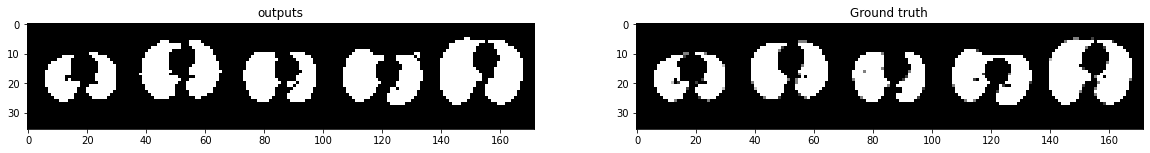

In [ ]:
batch = iter(val_dataloader).next()
with torch.no_grad(): outputs = model(batch['image'].float())
groundtruth = utils.make_grid(batch['mask'][:5] , nrow=5)
out = utils.make_grid(255*(outputs[:5] >= 0.5) , nrow=5)
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 20))
ax0.set_title('outputs')
ax1.set_title('Ground truth')
ax0.imshow(np.transpose(out.numpy(), (1, 2, 0)), interpolation='nearest')
ax1.imshow(np.transpose(groundtruth.numpy(), (1, 2, 0)), interpolation='nearest')

## Improve U-Net (bonus)

improve U-Net and compare accuracy and networks outputs with previous parts.

In [ ]:
# We already have 91.6% accuracy :)